## Artificial Neural Network

### Libraries

In [232]:
# standart data tools
import numpy as np
import pandas as pd

# common visualizing tools
import matplotlib.pyplot as plt
import seaborn as sns

# CNN layers and the Deep Learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# splitting tool for the validation set
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Data Loading

In [233]:
X = np.load('archive/X_2024-03-18_18-10-54.npy')
y = np.load('archive/Y_2024-03-18_18-10-54.npy')

### Splitting Train (70%), Validation (15%) and Test Datasets (15%)

In [234]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

x_train = x_train.reshape(-1, 64, 64, 1)
x_val = x_val.reshape(-1, 64, 64, 1)
x_test = x_test.reshape(-1, 64, 64, 1)

### Creating the ANN Model

In [235]:
ANN_model = Sequential([
  Flatten(),
  Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
  Dropout(0.3),
  Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
  Dropout(0.2),
  Dense(10, activation="softmax")
])

### Summary of the Model

In [236]:
ANN_model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_25 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilation

In [237]:
ANN_model.compile(optimizer=Adam(learning_rate=0.00002), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

### Training

In [238]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

results = ANN_model.fit(x_train, y_train, epochs=600, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/600


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1000 - loss: 3.6980 - val_accuracy: 0.1748 - val_loss: 3.4790
Epoch 2/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1327 - loss: 3.5436 - val_accuracy: 0.2136 - val_loss: 3.4372
Epoch 3/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1413 - loss: 3.4617 - val_accuracy: 0.2427 - val_loss: 3.3767
Epoch 4/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1854 - loss: 3.3856 - val_accuracy: 0.2654 - val_loss: 3.3274
Epoch 5/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2233 - loss: 3.3272 - val_accuracy: 0.3657 - val_loss: 3.2610
Epoch 6/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2316 - loss: 3.2919 - val_accuracy: 0.3754 - val_loss: 3.2132
Epoch 7/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2479 - loss: 3.2504 - val_accuracy: 0.3366 - val_loss: 3.1746
Epoch 8/600


KeyboardInterrupt: 

### Plotting Training and Validating Accuracy/Loss

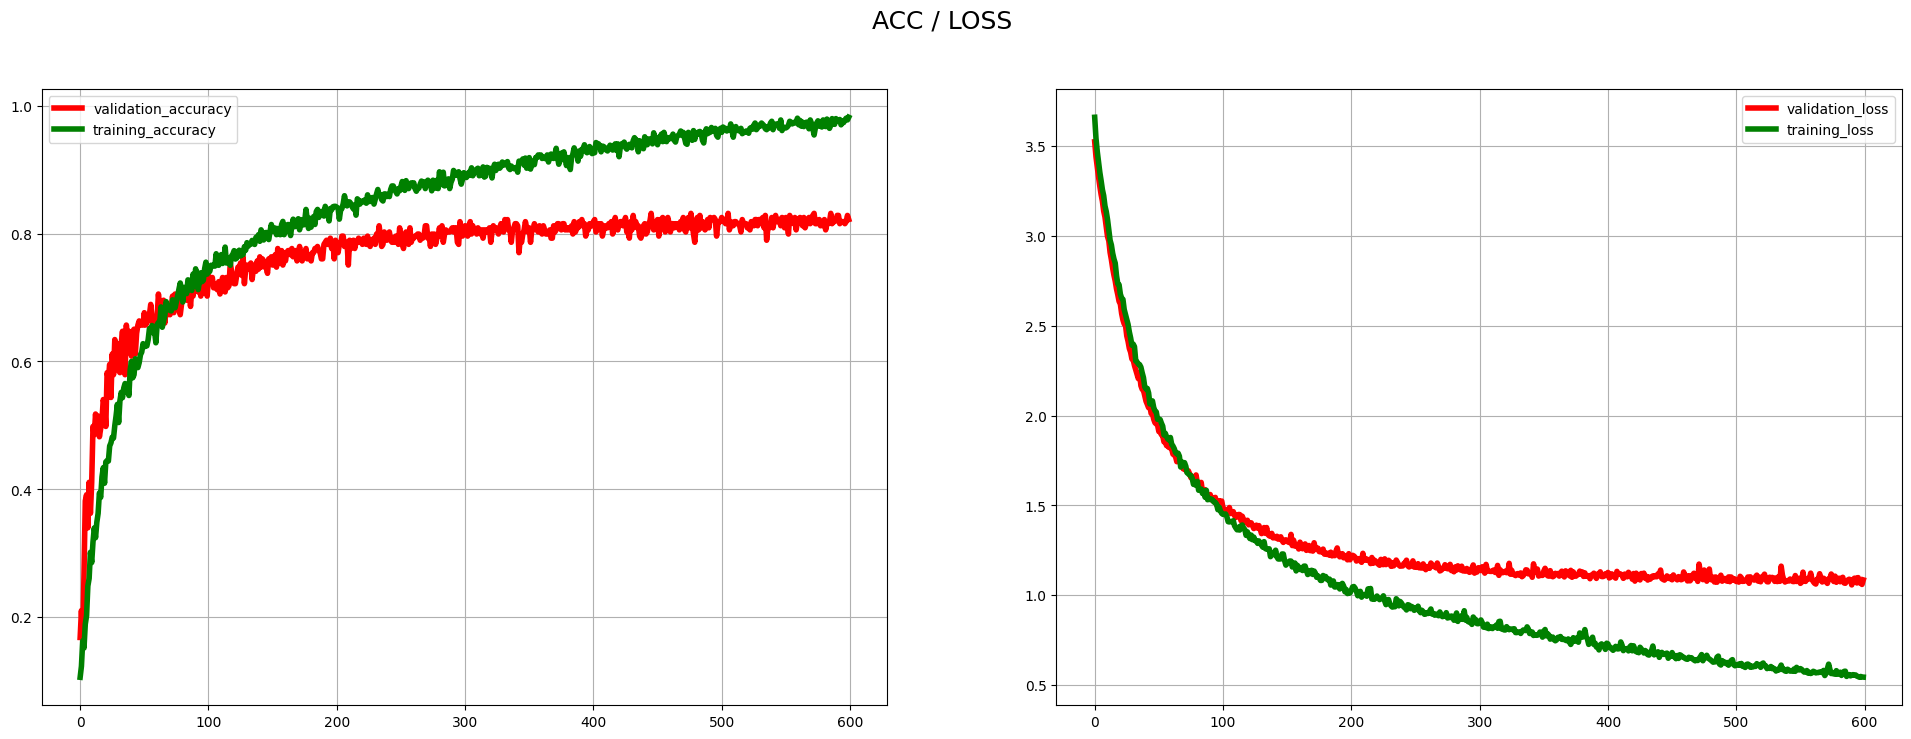

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(results.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(results.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(results.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

### Test Accuracy/Loss

In [ ]:
ANN_model.evaluate(x_test,y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8339 - loss: 0.9680 


[1.0073225498199463, 0.8290322422981262]

### Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


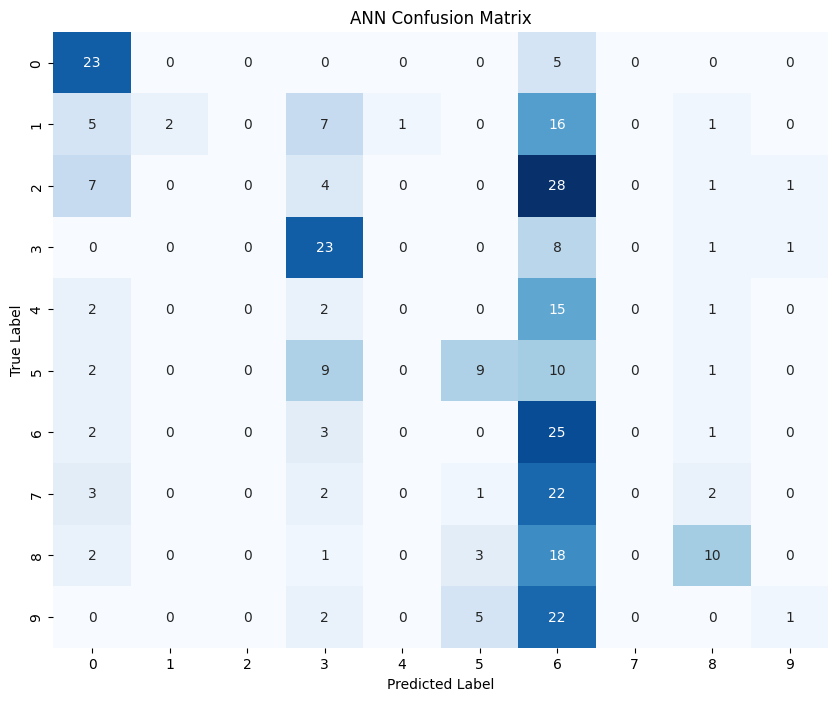

In [240]:
y_pred = ANN_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(np.argmax(y_test,axis=1),y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ANN Confusion Matrix')
plt.show()

### Predictions

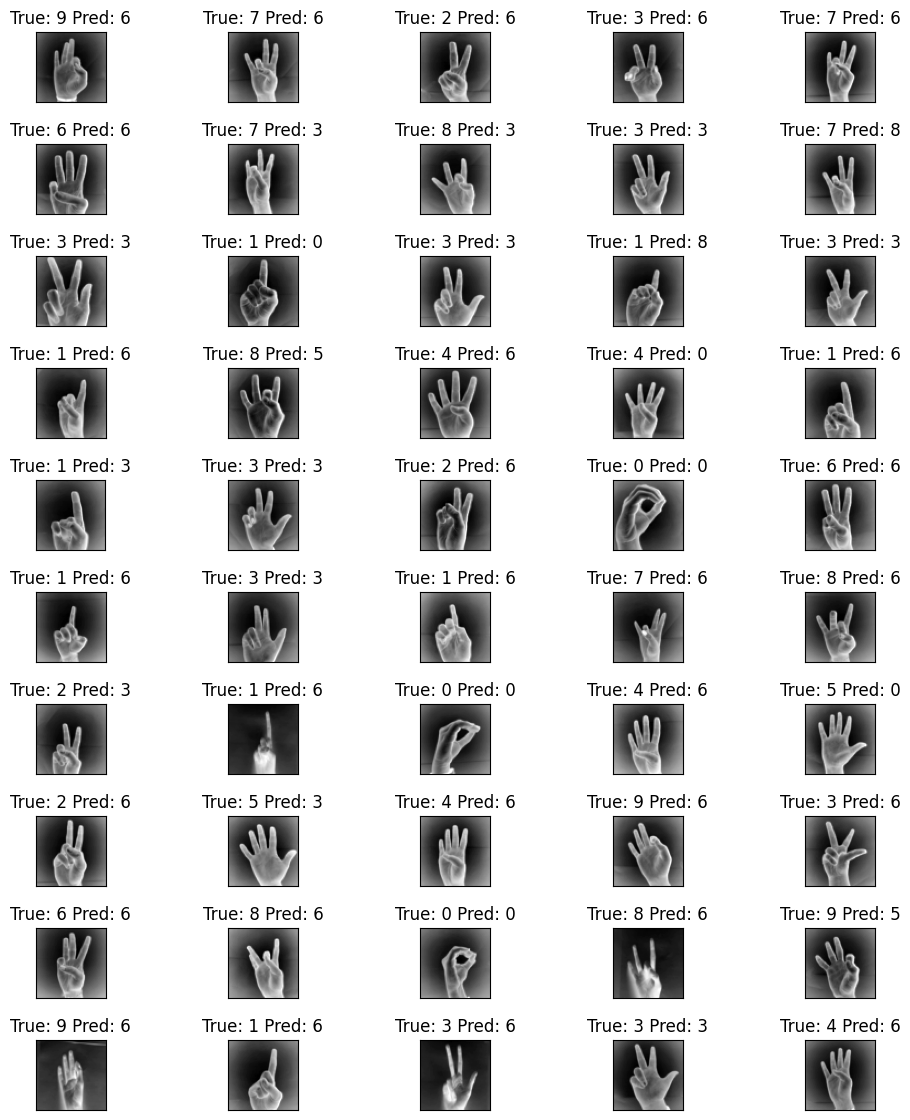

In [261]:
x_val_test =  x_test.reshape(x_test.shape[0], 64, 64)

fig , axis = plt.subplots(10, 5, figsize = (12, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_val_test[i], cmap = 'binary')
    ax.set(title = f"True: {y_test[i].argmax()} Pred: {y_pred[i].argmax()}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.6)
plt.show()